# Gaussianization Flows (Details)

In [1]:
#@title Install Packages
# %%capture
try:
    import sys, os
    from pyprojroot import here

    # spyder up to find the root
    root = here(project_files=[".here"])

    # append to path
    sys.path.append(str(root))
except ModuleNotFoundError:
    import os
    os.system("pip install objax chex")
    os.system("pip install git+https://github.com/IPL-UV/rbig_jax.git#egg=rbig_jax")

In [2]:
# jax packages
import jax
import jax.numpy as jnp
from jax.config import config

# import chex
config.update("jax_enable_x64", False)

import objax
import chex
import numpy as np
from functools import partial

# library functions
from rbig_jax.transforms.parametric.mixture.logistic import InitMixtureLogisticCDF
from rbig_jax.transforms.parametric.mixture.gaussian import InitMixtureGaussianCDF
from rbig_jax.transforms.logit import InitLogitTransform
from rbig_jax.transforms.inversecdf import InitInverseGaussCDF
from rbig_jax.transforms.parametric.householder import InitHouseHolder
from distrax._src.bijectors.sigmoid import Sigmoid
from distrax._src.bijectors.inverse import Inverse


KEY = jax.random.PRNGKey(123)

# logging
import tqdm
import wandb

# plot methods
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import corner
from IPython.display import HTML

sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)


%matplotlib inline
%load_ext lab_black
# %load_ext autoreload
# %autoreload 2

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


## Demo Data

In [44]:
from sklearn import datasets
from sklearn.preprocessing import StandardScaler

# %%wandb
# get data
seed = 123
n_samples = 5_000
noise = 0.075


def f(n_samples: int = 5_000, noise: float = 0.05, seed: int = 123):
    #     data, _ = datasets.make_moons(n_samples=n_samples, noise=noise, random_state=seed)
    data, _ = datasets.make_circles(
        n_samples=n_samples, noise=noise, random_state=seed, factor=0.5
    )
    return data


data = f(n_samples, noise, seed)

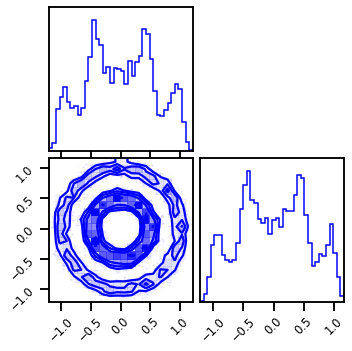

In [45]:
# plot data
fig = corner.corner(data, color="blue", hist_bin_factor=2)

In [46]:
X = jnp.array(data, dtype=np.float32)

## Model

#### Layer I - Mixture CDF

In [47]:
from rbig_jax.transforms.parametric.mixture.gaussian import InitMixtureGaussianCDF

In [48]:
# parameters
n_components = 12
n_features = 2
shape = (2,)
key = jax.random.PRNGKey(123)
init_method = "gmm"
method = "gaussian"

if method == "gaussian":
    init_mixcdf_f = InitMixtureLogisticCDF(
        n_components=n_components, init_method=init_method
    )
else:
    init_mixcdf_f = InitMixtureGaussianCDF(
        n_components=n_components, init_method=init_method
    )

#### Layer II - Logit/Inverse CDF Transform

In [49]:
# Logit Transformation
if method == "gaussian":
    init_logit_f = InitInverseGaussCDF()
else:
    init_logit_f = InitLogitTransform()

#### Layer III - HouseHolder Transformation

In [50]:
# Householder Transformation
n_reflections = 2
method = "random"

# initialize init function
init_hh_f = InitHouseHolder(n_reflections=n_reflections, method=method)

In [ ]:
init_mixcdf_f.

### Initializing The Model

CPU times: user 26.2 s, sys: 1min 12s, total: 1min 38s
Wall time: 6.02 s


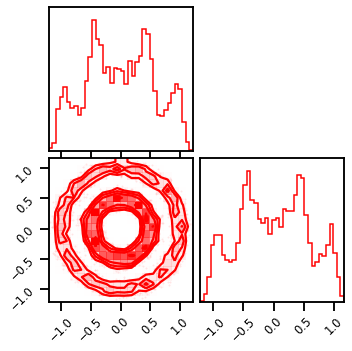

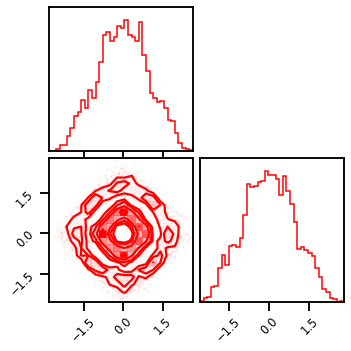

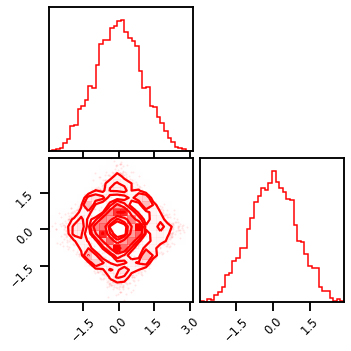

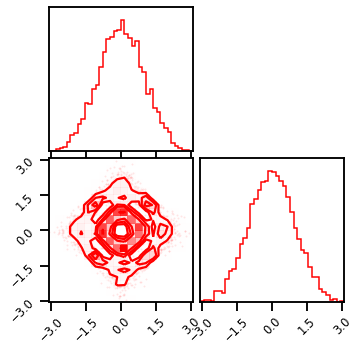

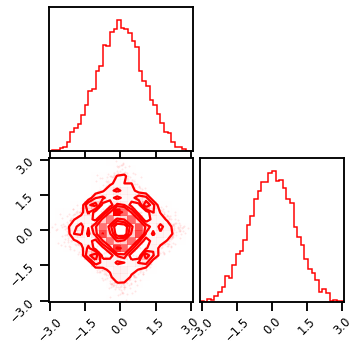

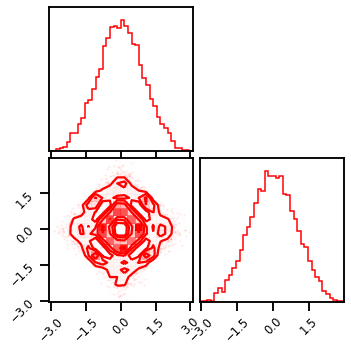

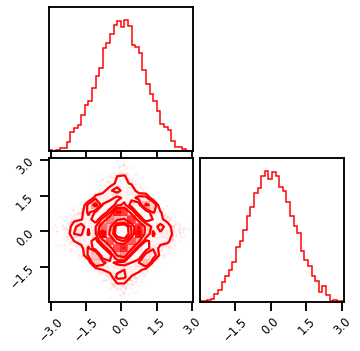

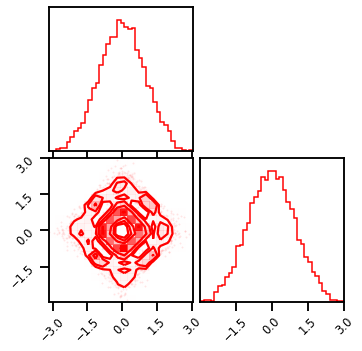

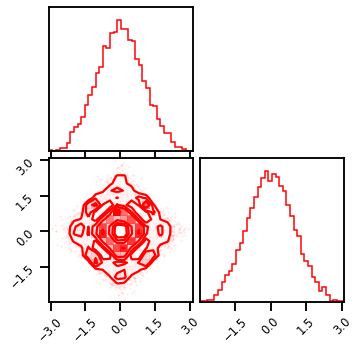

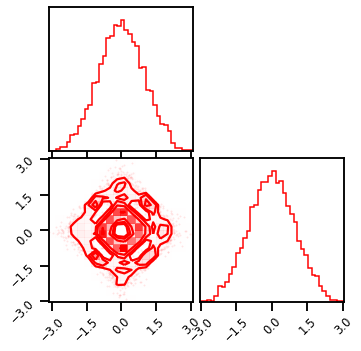

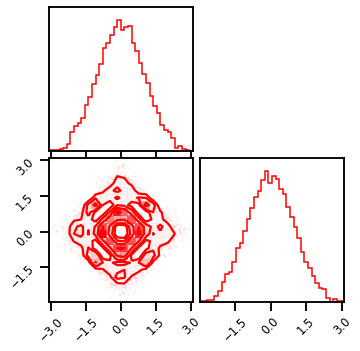

In [65]:
%%time

# Layer Params
n_layers = 10
bijectors = []

rng, *layer_rngs = jax.random.split(KEY, num=n_layers + 1)

X_g = X.copy()

# Plotting
plot_layers = True
plot_intermediates = False

if plot_layers:
    fig = corner.corner(X_g, color="red", hist_bin_factor=2)

for irng in layer_rngs:

    # ======================
    # MIXTURECDF
    # ======================
    # create keys for all inits
    irng, icdf_rng = jax.random.split(irng, 2)

    # intialize bijector and transformation
    X_g, layer = init_mixcdf_f.transform_and_bijector(
        inputs=X_g, rng=icdf_rng, n_features=n_features
    )

    # plot data
    if plot_layers and plot_intermediates:
        fig = corner.corner(X_g, color="red", hist_bin_factor=2)

    # add bijector to list
    bijectors.append(layer)

    # ======================
    # LOGIT
    # ======================

    # intialize bijector and transformation
    X_g, layer = init_logit_f.transform_and_bijector(inputs=X_g)

    bijectors.append(layer)

    # plot data
    if plot_layers and plot_intermediates:
        fig = corner.corner(X_g, color="red", hist_bin_factor=2)

    # ======================
    # HOUSEHOLDER
    # ======================

    # create keys for all inits
    irng, hh_rng = jax.random.split(irng, 2)

    # intialize bijector and transformation
    X_g, layer = init_hh_f.transform_and_bijector(
        inputs=X_g, rng=hh_rng, n_features=n_features
    )

    bijectors.append(layer)

    # plot data
    if plot_layers:
        fig = corner.corner(X_g, color="red", hist_bin_factor=2)

### Gaussianization Flow Model

In [80]:
from rbig_jax.models import GaussianizationFlow
from distrax._src.distributions.normal import Normal

# create base dist
base_dist = Normal(jnp.zeros((n_features,)), jnp.ones((n_features,)))

# create flow model
gf_model = GaussianizationFlow(base_dist=base_dist, bijectors=bijectors)

In [81]:
gf_model.score(X)

DeviceArray(1.4746871, dtype=float32)

## Training

### Optimizer

In [82]:
from rbig_jax.training.parametric import init_optimizer

In [83]:
# initialize optimizer
n_epochs = 5_000
optimizer = init_optimizer(
    "adam", lr=1e-3, cosine_decay_steps=None, gradient_norm_clip=1.0, alpha=1e-2,
)

### Trainer

In [84]:
from rbig_jax.training.parametric import GaussFlowTrainer


# initial flow trainer
nf_trainer = GaussFlowTrainer(gf_model, optimizer, n_epochs=n_epochs)

### Data Loaders

In [85]:
import tensorflow as tf
import tensorflow_datasets as tfds
from typing import Iterator, Mapping

Batch = Mapping[str, np.ndarray]


def create_dataset(
    batch_size: int,
    n_samples: int = 2_000,
    shuffle: bool = True,
    noise: float = 0.05,
    seed: int = 123,
) -> Iterator[Batch]:
    X = f(n_samples=n_samples, noise=noise, seed=seed)
    ds = tf.data.Dataset.from_tensor_slices((X))
    if shuffle:
        ds = ds.shuffle(buffer_size=10 * batch_size)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=5)
    ds = ds.repeat()
    return iter(tfds.as_numpy(ds))

In [86]:
n_train = 5_000
n_test = 1_000
batch_size = 256

ds_train = create_dataset(
    n_samples=n_train, shuffle=True, batch_size=batch_size, seed=123,
)
ds_valid = create_dataset(n_samples=n_test, shuffle=False, batch_size=n_test, seed=42)

### Train Model

In [87]:
eval_loss = 0.0
eval_frequency = 50
with tqdm.trange(n_epochs) as pbar:
    for step in pbar:

        # Train Step
        output = nf_trainer.train_step(next(ds_train))
        train_loss = output.loss
        pbar.set_description(
            f"Train Loss: {train_loss:.4f} | Valid Loss: {eval_loss:.4f}"
        )

        # Eval Step
        if step % eval_frequency == 0:
            output = nf_trainer.validation_step(next(ds_valid))
            eval_loss = output.loss
            pbar.set_description(
                f"Train Loss: {train_loss:.4f} | Valid Loss: {eval_loss:.4f}"
            )

gf_model = output.model

Train Loss: 0.5357 | Valid Loss: 0.6363: 100%|██████████| 5000/5000 [02:19<00:00, 35.87it/s] 


### Results

#### Losses

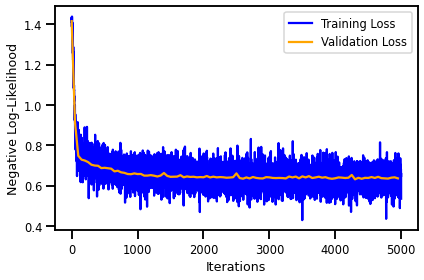

In [88]:
fig, ax = plt.subplots()
ax.plot(
    nf_trainer.train_epoch, nf_trainer.train_loss, label="Training Loss", color="blue"
)
ax.plot(
    nf_trainer.valid_epoch,
    nf_trainer.valid_loss,
    label="Validation Loss",
    color="orange",
)
ax.set(
    xlabel="Iterations", ylabel="Negative Log-Likelihood",
)
plt.legend()
plt.tight_layout()
plt.show()

#### Latent Space

CPU times: user 1.82 s, sys: 62.3 ms, total: 1.89 s
Wall time: 1.76 s


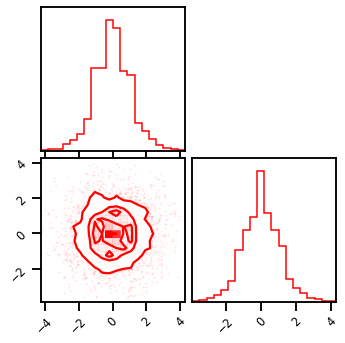

In [89]:
%%time
X_trans = gf_model.forward(X)

fig = corner.corner(X_trans, color="Red")

#### Inverse Transform

CPU times: user 58.8 s, sys: 4.58 s, total: 1min 3s
Wall time: 24.1 s


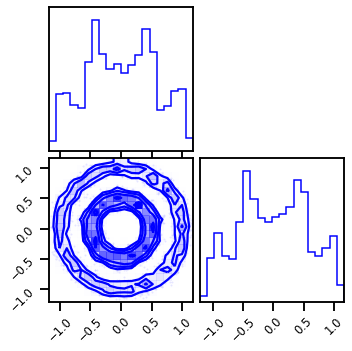

In [90]:
%%time

X_approx = gf_model.inverse(X_trans)

fig = corner.corner(X_approx, color="Blue")

### Log Probability

#### Plot: Original Density

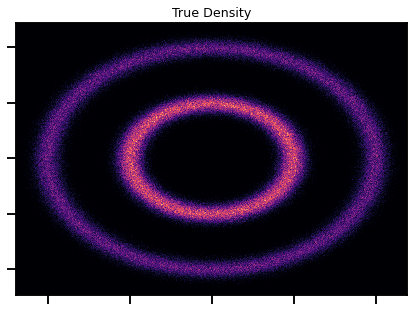

In [92]:
from matplotlib import cm

cmap = cm.magma
# Original Density
n_samples = 1_000_000
noise = 0.05
seed = 42
X_plot = f(n_samples=n_samples, noise=noise, seed=seed)


fig, ax = plt.subplots(figsize=(7, 5))
h = ax.hist2d(
    X_plot[:, 0], X_plot[:, 1], bins=512, cmap=cmap, density=True,  # vmin=0.0, vmax=1.0
)
ax.set_title("True Density")
ax.set(
    xlim=[X_plot[:, 0].min(), X_plot[:, 0].max()],
    ylim=[X_plot[:, 1].min(), X_plot[:, 1].max()],
    xticklabels="",
    yticklabels="",
)
plt.show()

### Plot Estimated Density

In [93]:
%%time

n_grid = 500
buffer = 0.01
xline = jnp.linspace(X[:, 0].min() - buffer, X[:, 0].max() + buffer, n_grid)
yline = jnp.linspace(X[:, 1].min() - buffer, X[:, 1].max() + buffer, n_grid)
xgrid, ygrid = jnp.meshgrid(xline, yline)
xyinput = jnp.concatenate([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)], axis=1)


# calculate log probability
X_log_prob = gf_model.score_samples(xyinput)

CPU times: user 7.29 s, sys: 2.47 s, total: 9.76 s
Wall time: 3.22 s


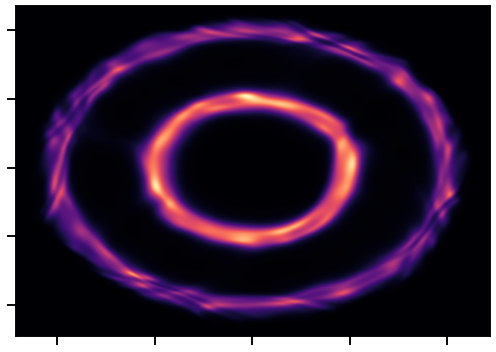

In [94]:
# Estimated Density
cmap = cm.magma  # "Reds"
probs = jnp.exp(X_log_prob)
# probs = np.clip(probs, 0.0, 1.0)
# probs = np.clip(probs, None, 0.0)


cmap = cm.magma  # "Reds"

fig, ax = plt.subplots(figsize=(7, 5))

h1 = ax.scatter(
    xyinput[:, 0],
    xyinput[:, 1],
    s=1,
    c=probs,
    cmap=cmap,
    #     vmax=0.01,  # vmin=0.0, vmax=1.0
)
ax.set(
    xlim=[xyinput[:, 0].min(), xyinput[:, 0].max()],
    ylim=[xyinput[:, 1].min(), xyinput[:, 1].max()],
    xticklabels="",
    yticklabels="",
)


plt.tight_layout()
plt.savefig("demo_jde")
plt.show()

### Sampling

In [95]:
%%time
n_gen_samples = 10_000
X_samples = gf_model.sample(seed=123, n_samples=n_gen_samples)

CPU times: user 1min 33s, sys: 3.54 s, total: 1min 36s
Wall time: 28.7 s


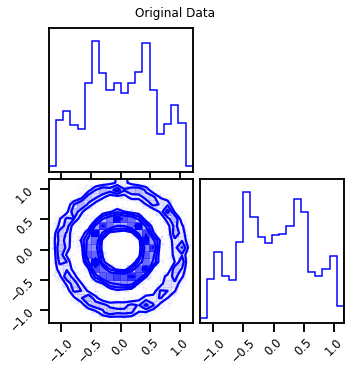

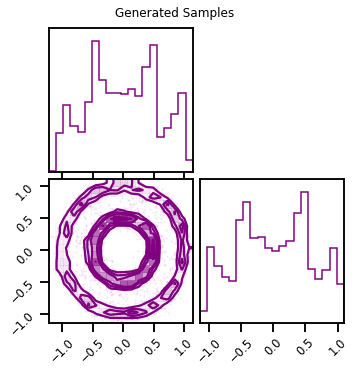

In [96]:
fig = corner.corner(np.array(X), color="blue", label="Original Data")
fig.suptitle("Original Data")
plt.show()

fig2 = corner.corner(np.array(X_samples), color="purple")
fig2.suptitle("Generated Samples")
plt.show()

## Each Layer

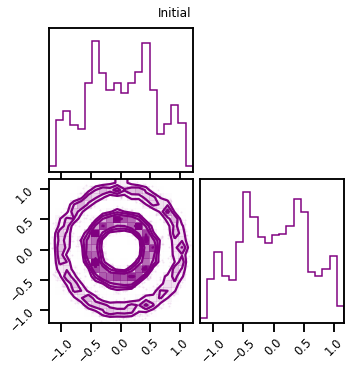

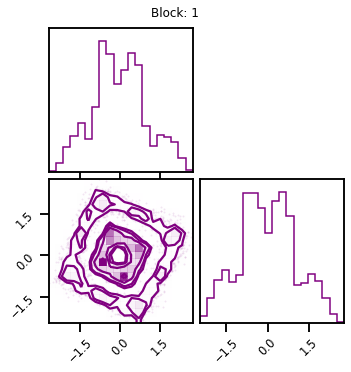

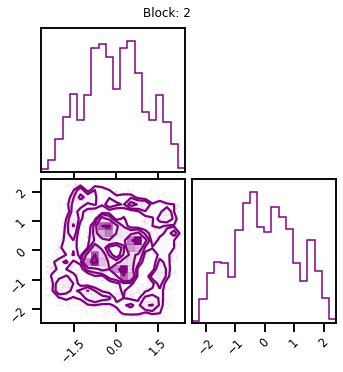

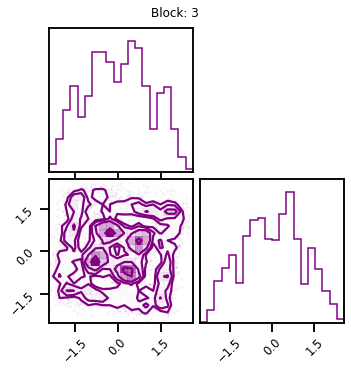

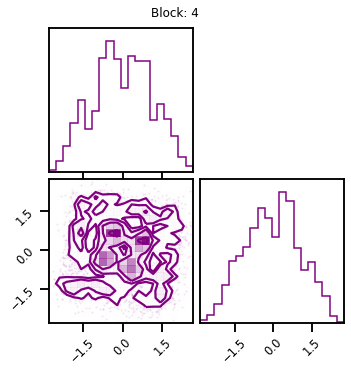

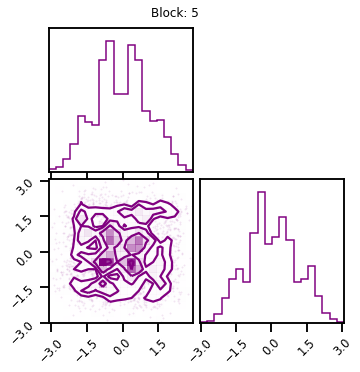

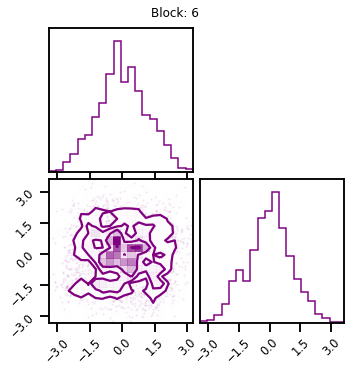

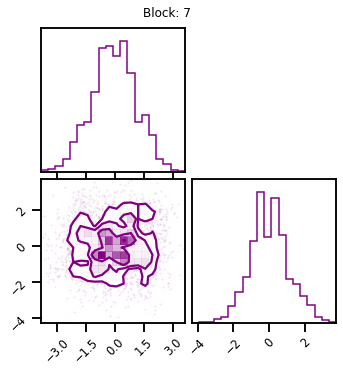

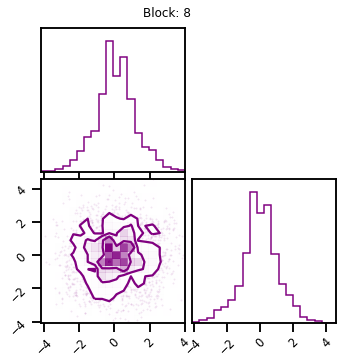

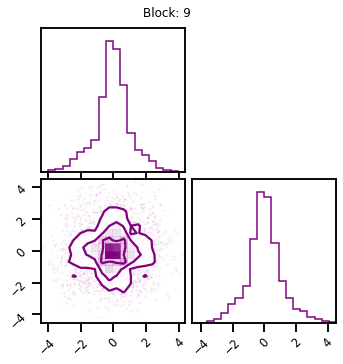

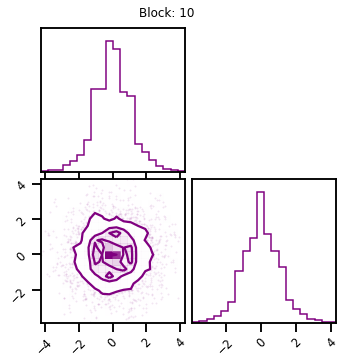

In [97]:
X_g = X.copy()

fig = corner.corner(X_g, color="purple")
fig.suptitle("Initial")

plt.show()

for ilayer, ibijector in enumerate(gf_model.bijectors):

    X_g = ibijector.forward(X_g)

    if ibijector.name == "HouseHolder":
        fig = corner.corner(np.array(X_g), color="purple")
        fig.suptitle(f"Block: {(ilayer+1)//3}")
        plt.show()

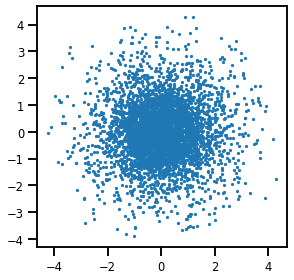

In [98]:
fig, ax = plt.subplots()
ax.scatter(X_g[:, 0], X_g[:, 1], s=3)
ax.set_aspect("equal", "box")
plt.tight_layout()

## Saving/Loading Model

#### Save Model

In [99]:
import joblib

joblib.dump(gf_model, "gf_model.pickle")

['gf_model.pickle']

#### Load Model

In [100]:
rbig_model_loaded = joblib.load("gf_model.pickle")